#CONFIGURAÇÕES DE AMBIENTE

**Aqui estão sendo instaladas e importadas todas as dependências necessárias para este projeto**


In [ ]:
!pip install gensim

In [ ]:
import re
import string
import gensim
import pandas as pd
import gensim.downloader as api
from gensim.models import Word2Vec
import numpy as np
import multiprocessing

# ÁREA DE TREINO

**LOAD DATASET**

Neste caso, o módulo gensim.downloader já possui o corpus text8 implementado e no intuito de agilizar tempo de processamento, estamos realizando uso deste corpus via api deste módulo.

In [ ]:
corpus = api.load('text8')

[==================================================] 100.0% 31.6/31.6MB downloaded


**TREINO DO MODELO**

Aqui especificamente, estamos treinando um modelo cbow, e segue uma breve explicação de alguns hiperparâmetros disponíveis para treinamento de Word2Vec no Gensim:

*   min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
*   window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
*   size = int - Dimensionality of the feature vectors. - (50, 300)
*   sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
*   alpha = float - The initial learning rate - (0.01, 0.05)
*   min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
*   negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
*   workers = int - Use these many worker threads to train the model (=faster training with multicore machines)



**MODELOS TESTADOS**

Para este trabalho, foram testados 4 modelos. No entanto, os modelos foram testados localmente, pois dessa forma foi possível paralelizar o treinamento em mais núcleos da CPU, diminuindo significativamente o tempo de treino.

Seguem os parâmetros utilizados:

1. **Modelo 1** (CBOW): {vector size = 400, sample = 6e-5, alpha = 0.03, min_alpha = 0.0007, workers = cores-1, epochs = 20}
2. **Modelo 2** (SkipGram): {vector size = 400, sample = 6e-5, alpha = 0.03, min_alpha=0.0007, workers=cores-1, sg=1, epochs=10}
3. **Modelo 3** (CBOW):{min_count=10,vector_size = 400,sample=6e-5,alpha=0.04,min_alpha=0.0007,workers=cores-1,sg=0,epochs=25}
4. **Modelo 4** (CBOW):{sentences=corpus, vector_size = 400, sample=6e-5,  alpha=0.03, min_alpha=0.0007, workers=cores-1, min_count = 20, window=3}


**IMPORTANTE**
Como o modelo foi treinado localmente, os parâmetros informados acima foram aplicados à um script que pode ser acessado em https://github.com/asiriaco/Word2Vec_NLP_UFMG/blob/main/train_models.py

O modelo que veremos abaixo sendo testado, é o modelo 1, que para efeito de visualização, também foi testado neste notebook


In [ ]:
cores = multiprocessing.cpu_count()

model = Word2Vec(
    sentences=corpus,
    vector_size = 400,
    sample=6e-5,
    alpha=0.03,
    min_alpha=0.0007,
    workers=cores-1,
)

model.build_vocab(corpus, progress_per=1000)

model.train(corpus, total_examples=model.corpus_count, epochs=20)

(172112903, 340104140)

**ALGUNS RESULTADOS**

Aqui podemos ver alguns resultados de analogias do modelo treinado para países e capitais. Para os exemplos abaixo, o modelo conseguiu acertar o vetor mais similar. Cabe ressaltar, que os outros *topn* vetores similares também se associam de alguma forma com a palavra alvo a ser prevista

In [ ]:
wv = model.wv
cities = ['lisbon', 'madrid', 'casablanca', 'canberra', 'beirut', 'tokyo', 'caracas', 'brussels', 'rome', 'beijing', 'budapest', 'damascus', 'cairo', 'kabul']
for city in ['lisbon', 'madrid', 'casablanca', 'canberra', 'beirut', 'tokyo', 'caracas', 'brussels', 'rome', 'beijing', 'budapest', 'damascus', 'cairo', 'kabul']:
  print(city, wv.most_similar(positive=['france', city], negative=['paris'], topn=3))

lisbon [('portugal', 0.4642293453216553), ('spain', 0.42397525906562805), ('galicia', 0.3886948227882385)]
madrid [('spain', 0.44888606667518616), ('galicia', 0.41034236550331116), ('portugal', 0.40672069787979126)]
casablanca [('morocco', 0.3794941008090973), ('agadir', 0.35284221172332764), ('spain', 0.3473208546638489)]
canberra [('australia', 0.41255417466163635), ('nsw', 0.3548338711261749), ('hmas', 0.3342224061489105)]
beirut [('lebanon', 0.39232897758483887), ('syria', 0.3697187304496765), ('liberia', 0.3481438457965851)]
tokyo [('japan', 0.4475755989551544), ('osaka', 0.4315579831600189), ('honshu', 0.39092546701431274)]
caracas [('venezuela', 0.43527695536613464), ('uruguay', 0.4084025025367737), ('fujimori', 0.3793788552284241)]
brussels [('belgium', 0.4351666271686554), ('wallonia', 0.40024247765541077), ('luxembourg', 0.39525115489959717)]
rome [('italy', 0.38709765672683716), ('visigoth', 0.3786389231681824), ('greece', 0.36885711550712585)]
beijing [('china', 0.399082183

In [ ]:
print(wv.most_similar(positive=['mango', 'men'], negative=['mangoes']))

[('women', 0.3811255991458893), ('man', 0.3461707532405853), ('people', 0.32859089970588684), ('centaur', 0.2933872938156128), ('beggar', 0.2777133882045746), ('him', 0.27059823274612427), ('mingled', 0.2704845070838928), ('dresses', 0.26500388979911804), ('he', 0.2649100124835968), ('angry', 0.2592480778694153)]


# DEMONSTRAÇÃO DE RESULTADOS

**COMPARANDO ACURÁCIA ENTRE MODELOS**

Para esta tarefa, foi escolhida a acurácia como métrica inicial de performance do modelo. A acurácia aqui está sendo utilizada apenas para escolher um dos quatro modelos para olhar mais detalhadamente suas previsões e distâncias.

A acurácia também foi calculada localmente utilizando o script que está disponível em https://github.com/asiriaco/Word2Vec_NLP_UFMG/blob/main/testing_questions.py. O arquivo utilizado para testar as acurácias pode ser encontrado em https://github.com/nicholas-leonard/word2vec/blob/master/questions-words.txt. Neste arquivo são disponibilizados diversos exemplos de analogias, e o trabalho feito no script mencionado foi de "esconder" a última palavra da analogia e deixar o modelo fornecer a previsão.
A acurácia foi medida utilizando **NÚMERO DE PREVISÕES CERTAS/NÚMERO TOTAL DE PREVISÕES**

Para cada modelo, o script de teste das questões foi rodado e as acurácias separadas por classe de analogia. Os arquivos contendo as acurácias por classe de analogia podem ser encontrados em: https://github.com/asiriaco/Word2Vec_NLP_UFMG/tree/main/accuracies



,capital-common-countries,capital-world,currency,city-in-state,family,gram1-adjective-to-adverb,gram2-opposite,gram3-comparative,gram4-superlative,gram5-present-participle,gram6-nationality-adjective,gram7-past-tense,gram8-plural
Model 1,0.701581,0.327722,0.083218,0.274249,0.582766,0.102823,0.114796,0.552553,0.211174,0.274621,0.670513,0.302564,0.361111
Model 2,0.658103,0.275814,0.099861,0.306438,0.301587,0.023185,0.047194,0.210210,0.067235,0.102273,0.719872,0.191667,0.314565
Model 3,0.719368,0.338002,0.083596,0.252427,0.503759,0.117586,0.077295,0.509009,0.225108,0.300189,0.646154,0.316897,0.413492
Model 4,0.666008,0.280133,0.074132,0.226699,0.506266,0.085328,0.069243,0.493243,0.186147,0.263258,0.641667,0.323471,0.438095


<function matplotlib.pyplot.show(close=None, block=None)>

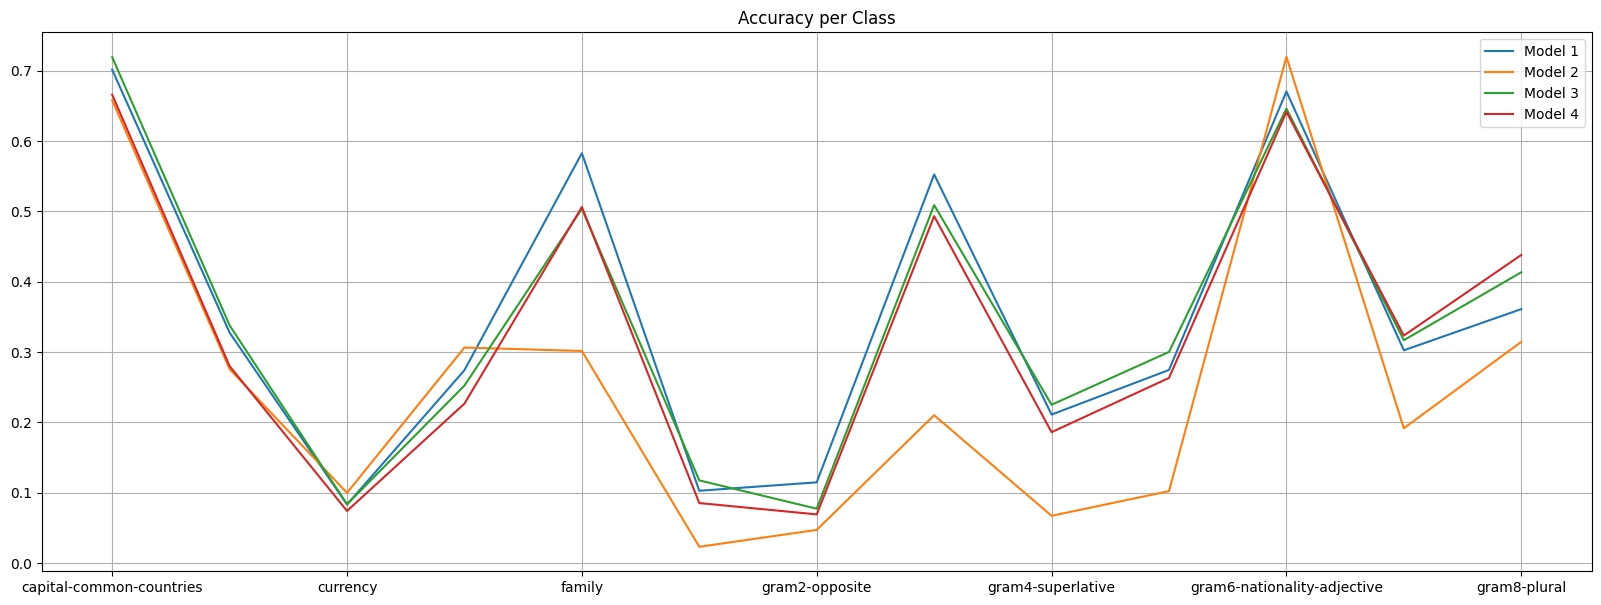

In [ ]:
import matplotlib.pyplot as plt

files = ["accuracies_per_model/model{}_accuracies.csv".format(i) for i in range (1,5)]
accuracies = [pd.read_csv(fpath) for fpath in files]
df_acc = pd.concat(acc for acc in accuracies)

#df_acc = pd.concat(acc for acc in accuracies)
df_acc.index = ["Model {}".format(i) for i in range(1,5)]

display(df_acc)

df_T = df_acc.T
df_T.plot(figsize=(20, 7), grid='y', title='Accuracy per Class')
plt.show


**COMPARANDO ACURÁCIA TOTAL ENTRE MODELOS**

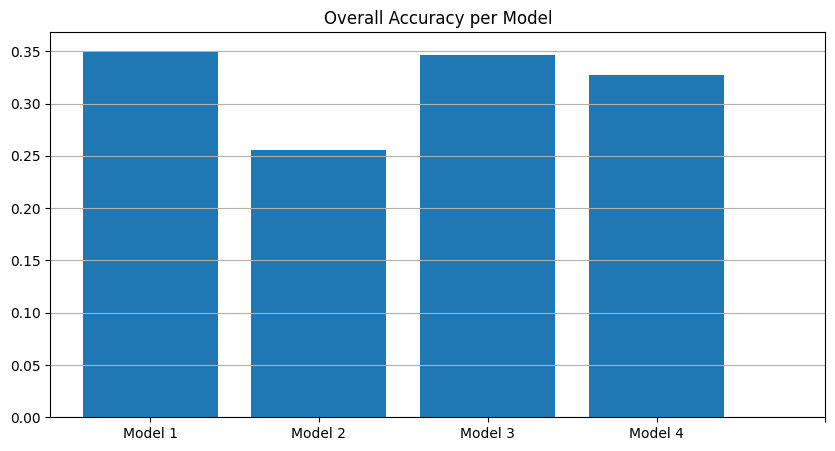

In [ ]:
overall_acuracies_per_model = [acc.mean(axis=1)[0] for acc in accuracies]


plt.figure(figsize=(10,5))
plt.bar(["Model {}".format(i) for i in range(1,5)], overall_acuracies_per_model)
plt.xticks(np.arange(0, 5, 1))
plt.grid(axis='y')
plt.title("Overall Accuracy per Model")
plt.show()



# ENTENDENDO OS ERROS

**AMOSTRAGEM**

Como o **MODELO 1** se mostrou o mais equilibrado nas previsões, utilizaremos ele para ter uma ideia de como as previsões se comportaram matemáticamente. Para isso, utilizaremos uma amostra das previsões erradas feitas pelo modelo em questão. A amostra completa pode ser encontrada em https://github.com/asiriaco/Word2Vec_NLP_UFMG/blob/main/error_samples_model1.csv.

Vamos, também, calcular a similaridade do cosseno entre a palavra alvo (correta) e a palavra predita pelo modelo (equivocada)

In [ ]:
df = pd.read_csv("error_samples_model1.csv")
df = df.drop(['Unnamed: 0'], axis=1)
df_sample = df.sample(frac=0.04, replace=True, random_state=4).reset_index(drop=True)
display(df_sample)
df_sample['Cosine Similarity'] = [model.wv.distance(row['Target'], row['Predicted']) for index, row in df_sample.iterrows()]


,Word1,Word2,Word3,Target,Predicted
0,rome,italy,bangkok,thailand,narita
1,rome,italy,helsinki,finland,espoo
2,moscow,russia,havana,cuba,azores
3,london,england,bern,switzerland,aargau
4,canberra,australia,athens,greece,aegina
5,stockholm,sweden,bern,switzerland,aargau


**PREPARAÇÃO DOS VETORES PARA PLOTAR**

Aqui utilizaremos a técnica PCA para redução da dimensionalidade dos vetores de palavras, para que possamos representá-los graficamente em duas dimensões e análisar a distância do que deveria ser predito para o que atualmente foi predito.

In [ ]:
from sklearn.decomposition import PCA


words = [list(df_sample['Target']), list(df_sample['Predicted'])]
sample_vectors = np.array([wv[word] for word in words])

pca = PCA(n_components=2)
sample_vectors_target, sample_vectors_predicted = sample_vectors[0], sample_vectors[1]
pca.fit(sample_vectors_target)
pca.fit(sample_vectors_predicted)

result_target = pca.transform(sample_vectors_target)
result_predicted = pca.transform(sample_vectors_predicted)

print(result_target.shape, result_predicted.shape)

(6, 2) (6, 2)


**DEMONSTRAÇÃO DOS RESULTADOS**

Aqui iremos demonstrar graficamente a distância das palavras alvo para as palavras preditas. Notem que os pares de (alvo, preditas) estão representadas no gráfico por pontos da mesma cor.

**CONCLUSÕES**
Na maioria dos casos analisados, as palavras preditas possuem certa proximidade semântica com a palavra alvo, mas por limitações do modelo e do dataset não conseguiram chegar efetivamente na palavra correta.

Ex:


*   Aargau é um cantão da Suíça
*   Espoo é uma cidade da Finlândia
*   Aegina é uma ilha da Grécia

Para melhorar o desempenho na analogia de países, deve-se considerar a utilização de um outro dataset ou o treino de modelos mais robustos para o treino dos WordEmbeddings.

,Word1,Word2,Word3,Target,Predicted,Cosine Similarity
0,rome,italy,bangkok,thailand,narita,0.749471
1,rome,italy,helsinki,finland,espoo,0.663991
2,moscow,russia,havana,cuba,azores,0.713333
3,london,england,bern,switzerland,aargau,0.617982
4,canberra,australia,athens,greece,aegina,0.651545
5,stockholm,sweden,bern,switzerland,aargau,0.617982


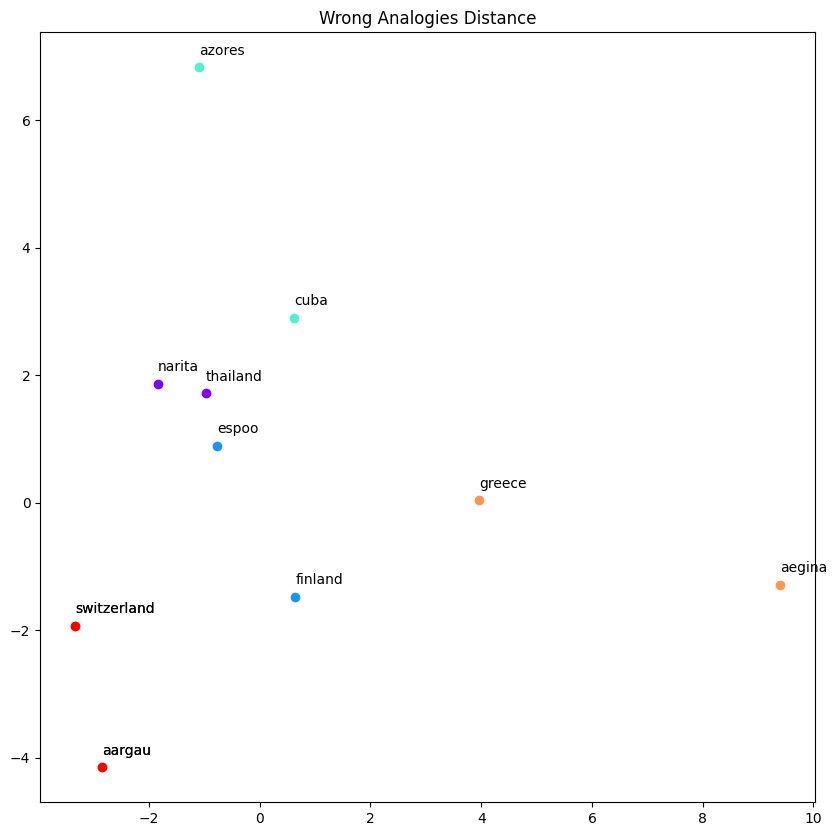

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

display(df_sample)
colors = cm.rainbow(np.linspace(0, 1, result_target.shape[0]))

labels = []
for t, p in zip(words[0], words[1]):
  labels.append((t, p))

plt.figure(figsize=(10, 10))
plt.title("Wrong Analogies Distance")
for coord1, coord2, color, label in zip(result_target, result_predicted, colors, labels):
  plt.scatter(x=coord1[0], y=coord1[1], color=color)
  plt.annotate(label[0], (coord1[0], coord1[1]+0.2))
  plt.scatter(x=coord2[0], y=coord2[1], color=color)
  plt.annotate(label[1], (coord2[0], coord2[1]+0.2))

